# State dependent exponential distribution

### How it was implemented:
- No need to implement anything in ciw
- Create a class that inherits from `ciw.dists.Distriution`
- Write a new `__init__` method and a new `sample` method  

In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
class StateDependentExponential(ciw.dists.Distribution):
    def __init__(self, rates):
        if any(rate <= 0 for rate in rates.values()):
            raise ValueError('Exponential distribution must sample positive numbers only.')
        self.rates = rates

    def sample(self, t=None, ind=None):
        state = ind.simulation.statetracker.state
        rate = self.rates[state[0]]
        return random.expovariate(rate)

In [7]:
N_1 = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate=2)],
    service_distributions=[ciw.dists.Exponential(rate=1)],
    number_of_servers=[2],
    queue_capacities=[2],
)

rates = {
    0: 1, 
    1: 2, 
    2: 3,
    3: 4,
    # 4: 1,
}
N_2 = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate=2)],
    service_distributions=[StateDependentExponential(rates=rates)],
    number_of_servers=[2],
    queue_capacities=[2],
)

In [8]:
# Normal simulation
ciw.seed(0)
Q = ciw.Simulation(N_1, tracker=ciw.trackers.NodePopulation())
Q.simulate_until_max_time(100)
recs = Q.get_all_records()
print("Mean waiting time:", np.mean([r.waiting_time for r in recs]))

# Simulation with state dependent service rate
ciw.seed(0)
Q = ciw.Simulation(N_2, tracker=ciw.trackers.NodePopulation())
Q.simulate_until_max_time(100)
recs = Q.get_all_records()
print("Mean waiting time:", np.mean([r.waiting_time for r in recs]))

Mean waiting time: 0.4369621600647264
Mean waiting time: 0.08772084856257466


## Emergency Department application

In [9]:
import numpy as np
import ambulance_game as abg

### Parameters

In [10]:
lambda_1 = 1
lambda_2 = 0.25
mu = 0.2
num_of_servers = 3
threshold = 4
system_capacity = 10
buffer_capacity = 5

runtime = 1000
seed_num = 0

### Markov model

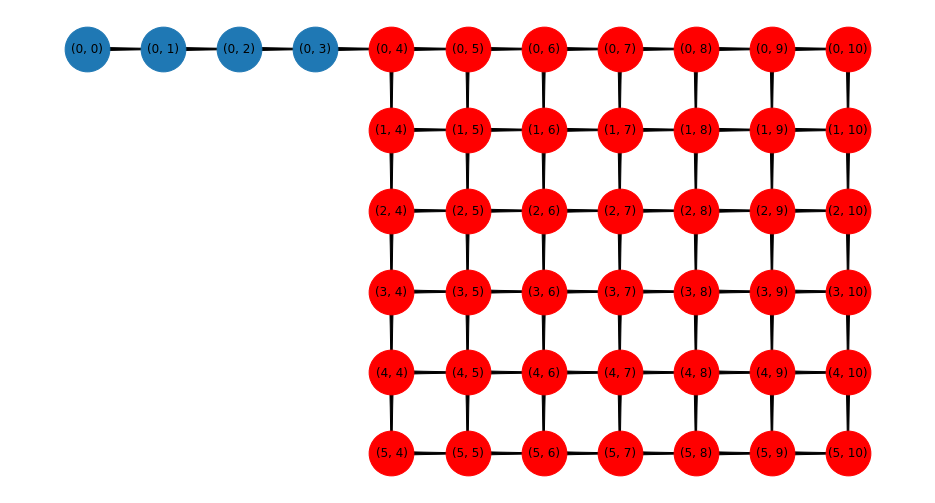

In [11]:
G = abg.markov.visualise_markov_chain(
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
)

### Normal simualtion VS simulation with state dependent distributions

In [12]:
mu = 0.2

In [13]:
Q = abg.simulation.simulate_model(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    seed_num=seed_num,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    runtime=runtime,
)

In [16]:
Q_state_dep = abg.simulation.simulate_model(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu={
        (u, v): mu if v < threshold else 4*mu
        for u in range(11) for v in range(11)
    },
    num_of_servers=num_of_servers,
    threshold=threshold,
    seed_num=seed_num,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    runtime=runtime,
)

### Waiting time

In [17]:
wait = np.mean([w.waiting_time for w in Q.get_all_records()])
wait_state_dep = np.mean([w.waiting_time for w in Q_state_dep.get_all_records()])

print(f"Mean waiting time (normal simulation): {wait}")
print(f"Mean waiting time ( state dependent ): {wait_state_dep}")

Mean waiting time (normal simulation): 9.844150224057087
Mean waiting time ( state dependent ): 1.8039963901117286


### Server busy time

In [18]:
all_times = [s.busy_time for s in Q.nodes[2].servers]
all_times_state_dep = [s.busy_time for s in Q_state_dep.nodes[2].servers]

print("\t\t\t Servers busy times")
print("\t- Normal simulation - \t - State dependent simulation -")
for i, (s, s_state_dep) in enumerate(zip(all_times, all_times_state_dep)):
    print(f"Server {i+1}:  {round(s, 12)},            {round(s_state_dep, 12)}")

			 Servers busy times
	- Normal simulation - 	 - State dependent simulation -
Server 1:  998.581370847028,            969.367144853305
Server 2:  998.281728534814,            957.480924313213
Server 3:  997.762645348613,            946.05872254247
